# Transfer learning for Expression prediction using VGGNET by adding layers 

## Importing Libraries

In [1]:
 # importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading and viewing the dataset
df = pd.read_csv('FaceExpressions/data.csv', index_col=0)
df.head()


path     label
0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4       Surprise/cropped_emotions.263616~12fffff.png  Surprise

In [3]:
# getiing the target varibale
df['label'].value_counts()

Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: label, dtype: int64

In [4]:
# creating the global variables
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 75
EPOCHS = 50
DATA = 600

## Data Preprocessing

In [5]:
# dropping the unnecessary data
df = df[df['label'] != 'Ahegao']
df['label'].value_counts()

Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Name: label, dtype: int64

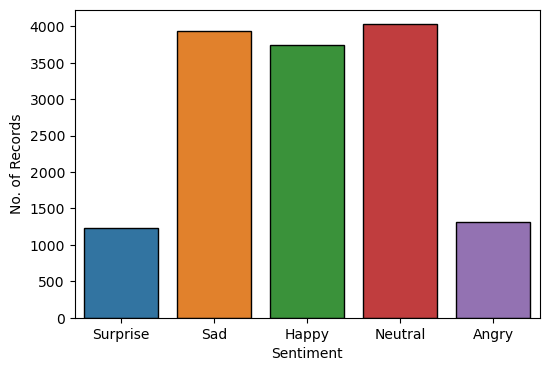

In [6]:
# Plotting the remaining data
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('No. of Records')
plt.show()

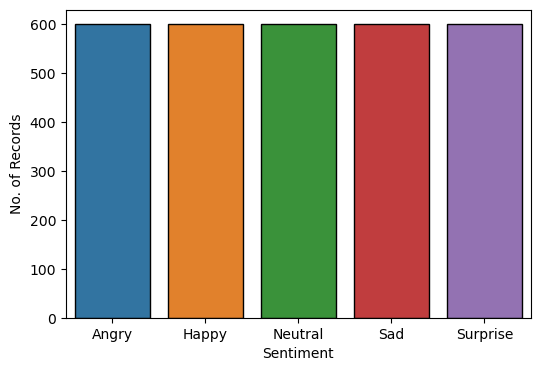

In [7]:
# selecting random 3000 data per sentiment

df = df.groupby('label').sample(DATA).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('No. of Records')
plt.show()

In [8]:
# performing label encoding on target variable
label_encoding = LabelEncoder()
df['label'] = label_encoding.fit_transform(df['label'])

In [9]:
# loading the face expression data
def load_data():

    images = []
    labels = []

    # iterating over each row dataset
    for i, data in df.iterrows():
        image_path = 'FaceExpressions/dataset/' + data['path']
        label = data['label']

        # resizing all the images
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)

#         # gray scaling
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         # gaussian blur
#         image = cv2.GaussianBlur(image, (5, 5), 0)
#         # histogram equalization
#         image = cv2.equalizeHist(image)
#         # intensity thresholding
#         _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
#         # rgb
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# removing these things from code because it was not giving good accuracy

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    images = images.astype("float32") / 255.0
    labels = to_categorical(labels, 5)


    return images, labels

In [10]:
# reading the image and its corresponding label
img, lab = load_data()
print(f'Image :- {img[25]}')
print(f'Label :- {lab[25]}')

Image :- [[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.1764706  0.18039216 0.2       ]
  [0.15294118 0.15294118 0.1764706 ]
  [0.15686275 0.15686275 0.18039216]
  ...
  [0.16470589 0.18039216 0.20392157]
  [0.19215687 0.22352941 0.25882354]
  [0.21960784 0.26666668 0.32941177]]

 [[0.13725491 0.14117648 0.15686275]
  [0.16470589 0.16862746 0.18431373]
  [0.18039216 0.18431373 0.20392157]
  ...
  [0.19215687 0.20784314 0.23137255]
  [0.16078432 0.19215687 0.22352941]
  [0.18039216 0.21960784 0.27450982]]

 ...

 [[0.12941177 0.16470589 0.20784314]
  [0.08627451 0.11372549 0.14509805]
  [0.08235294 0.09803922 0.13333334]
  ...
  [0.18039216 0.21176471 0.27058825]
  [0.21568628 0.24705882 0.3019608 ]
  [0.13725491 0.15294118 0.20392157]]

 [[0.22352941 0.24705882 0.32941177]
  [0.20392157 0.21960784 0.2

## Train Test Split

In [11]:
# splitting data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(img, lab, test_size=0.2, random_state=101, stratify=lab)

print('Training Set', X_train.shape, y_train.shape)
print('Testing Set', X_test.shape, y_test.shape)

Training Set (2400, 128, 128, 3) (2400, 5)
Testing Set (600, 128, 128, 3) (600, 5)


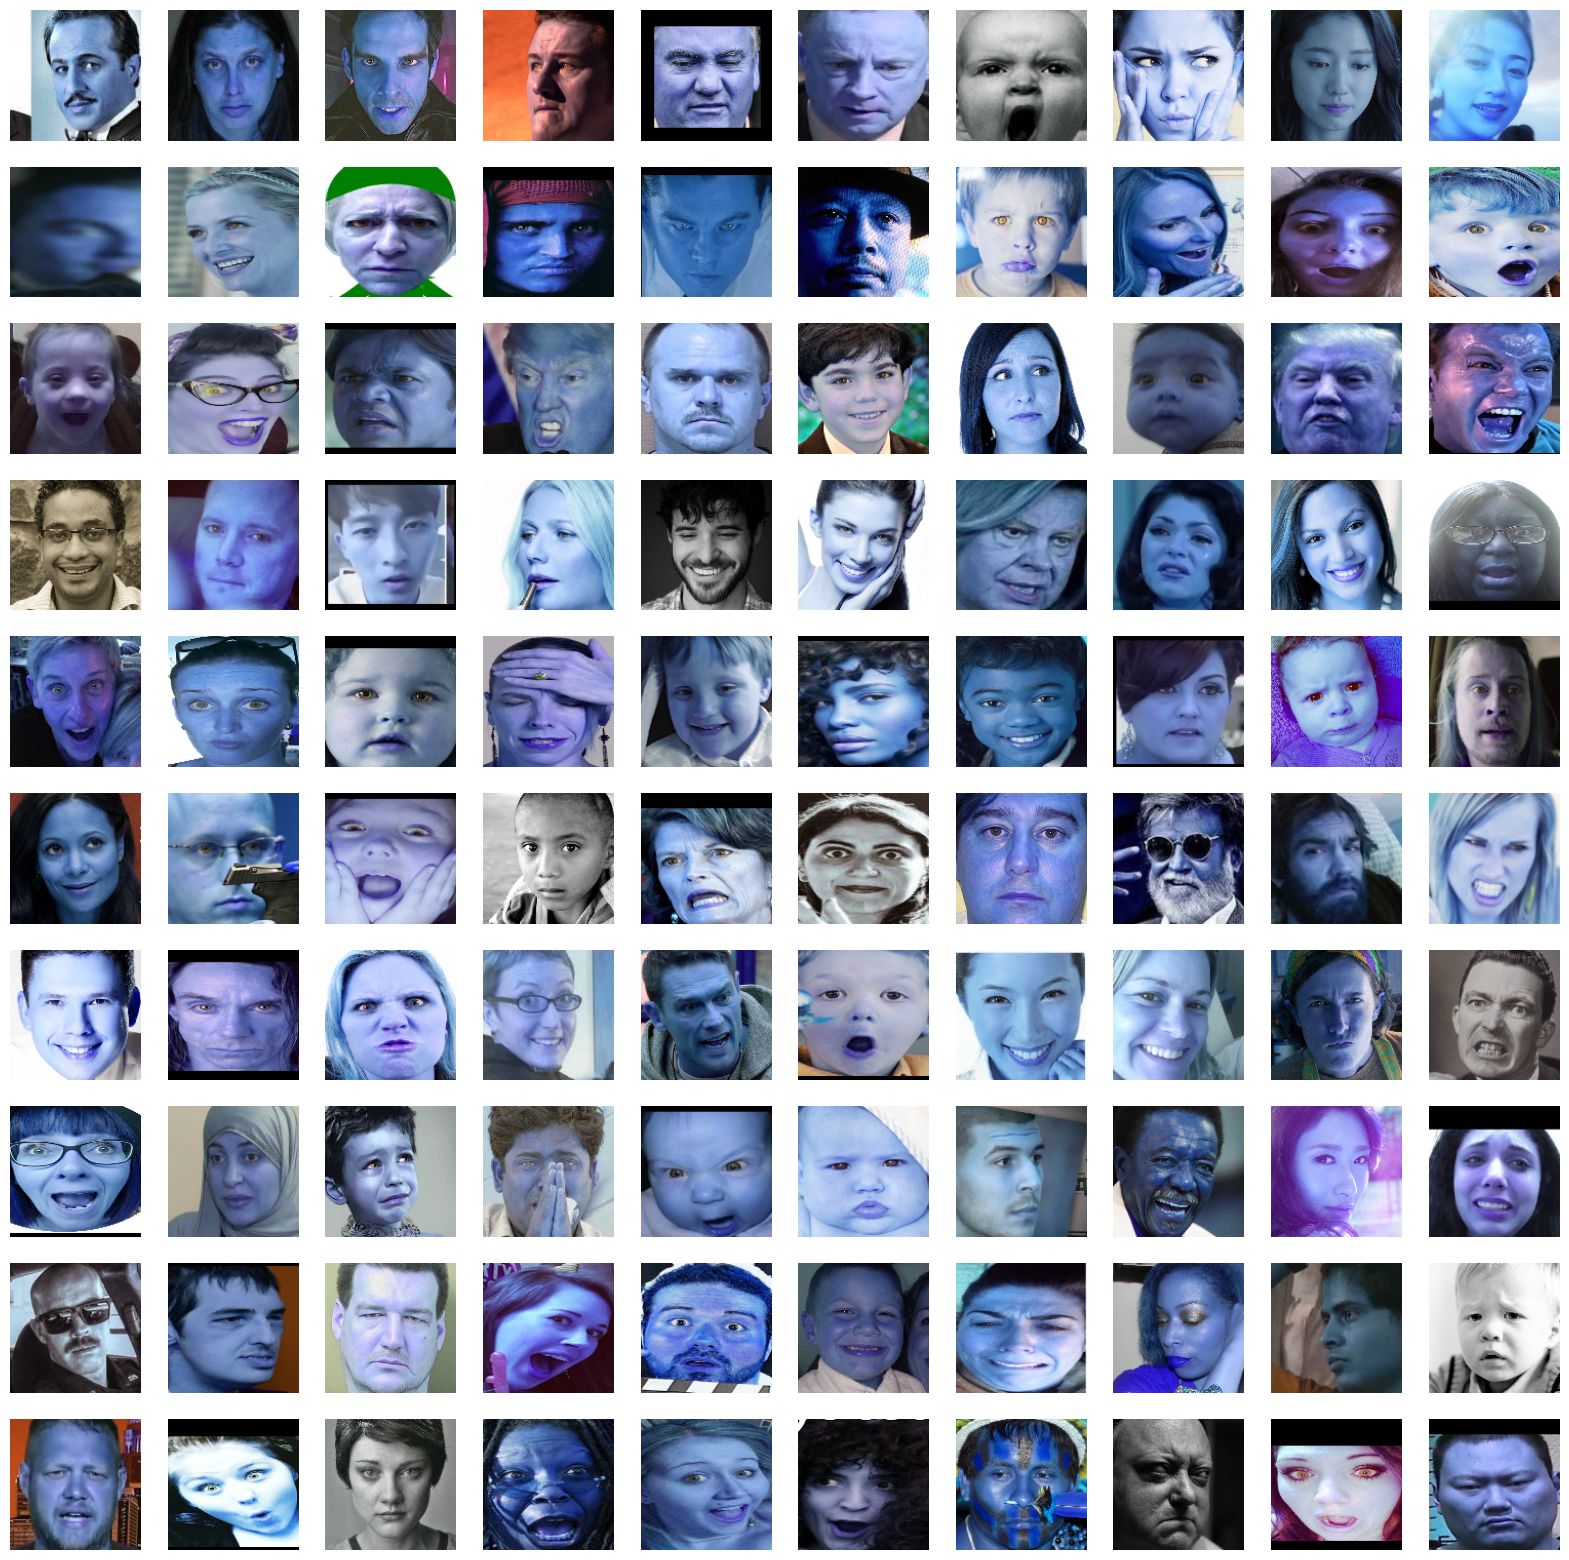

In [12]:
# plotting the faces
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

## Data Augmentation

In [13]:
# performing the data augmentation
train_gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_data = train_gen.flow(
    X_train,
    y_train
)

In [15]:
# printing shapes of data ti verify the split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 128, 128, 3)
(600, 128, 128, 3)
(2400, 5)
(600, 5)


## Model Building

## VGGNET-19

In [16]:
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
vgg_model.trainable = False

In [17]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Adding Layers to VGGNET

In [18]:
# Adding more layers
model = Sequential([
    vgg_model,
    Conv2D(256, (3,3), activation='relu'),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(128, activation='relu'),
#     Dropout(0.25),
    Dense(64, activation='relu'),
#     Dropout(0.3),
    Dense(32, activation='relu'),
#     Dropout(0.2),
    Dense(5, activation='softmax')
])

# compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# stopping early according to accuracy
earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True, verbose=1)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 256)         1179904   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8

## Model Training

In [21]:
# training the transfer learning on VGGNET-19 model
start_time = time.time()
model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[earlystop])
end_time = time.time()

Epoch 1/50


75/75 [==============================] - 126s 2s/step - loss: 1.8425 - accuracy: 0.2346 - val_loss: 1.6960 - val_accuracy: 0.2767
Epoch 2/50
75/75 [==============================] - 132s 2s/step - loss: 1.6644 - accuracy: 0.2792 - val_loss: 1.6219 - val_accuracy: 0.3017
Epoch 3/50
75/75 [==============================] - 138s 2s/step - loss: 1.5805 - accuracy: 0.3208 - val_loss: 1.5931 - val_accuracy: 0.2733
Epoch 4/50
75/75 [==============================] - 133s 2s/step - loss: 1.5254 - accuracy: 0.3658 - val_loss: 1.5046 - val_accuracy: 0.3567
Epoch 5/50
75/75 [==============================] - 141s 2s/step - loss: 1.4624 - accuracy: 0.3967 - val_loss: 1.4261 - val_accuracy: 0.3917
Epoch 6/50
75/75 [==============================] - 137s 2s/step - loss: 1.4173 - accuracy: 0.4108 - val_loss: 1.3426 - val_accuracy: 0.4533
Epoch 7/50
75/75 [==============================] - 136s 2s/step - loss: 1.4018 - accuracy: 0.4250 - val_loss: 1.4087 - val_accuracy: 0.4500
Epoch 8/50


## Model Performance

<AxesSubplot:>

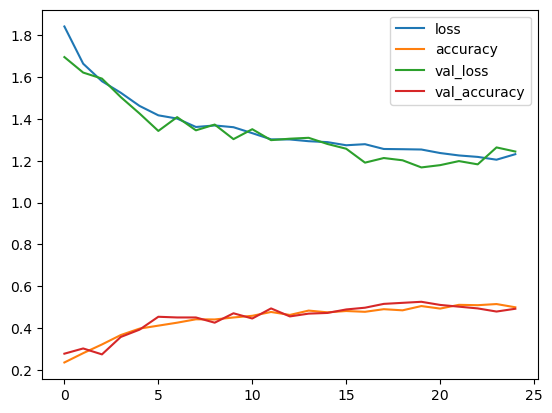

In [22]:
# loss function
loss = pd.DataFrame(model.history.history)
loss.plot()

In [23]:
# model training time
train_time = end_time - start_time
print(f'Model Training Time :- {round(train_time, 2)}s')

Model Training Time :- 3446.21s


### Performance on training data

In [24]:
# predicting the model on train data
x_pred = model.predict(X_train)

x_true = np.argmax(y_train, axis=1)
x_prd = np.argmax(x_pred, axis=1)

accuracy = accuracy_score(x_true, x_prd)
print(f'Train Accuracy:- {round(accuracy*100, 2)}%')

75/75 [==============================] - 114s 2s/step
Train Accuracy:- 56.92%


In [25]:
# getting the classification report
print(classification_report(x_true, x_prd))

              precision    recall  f1-score   support

           0       0.54      0.69      0.61       480
           1       0.58      0.69      0.63       480
           2       0.50      0.47      0.48       480
           3       0.49      0.30      0.37       480
           4       0.70      0.70      0.70       480

    accuracy                           0.57      2400
   macro avg       0.56      0.57      0.56      2400
weighted avg       0.56      0.57      0.56      2400



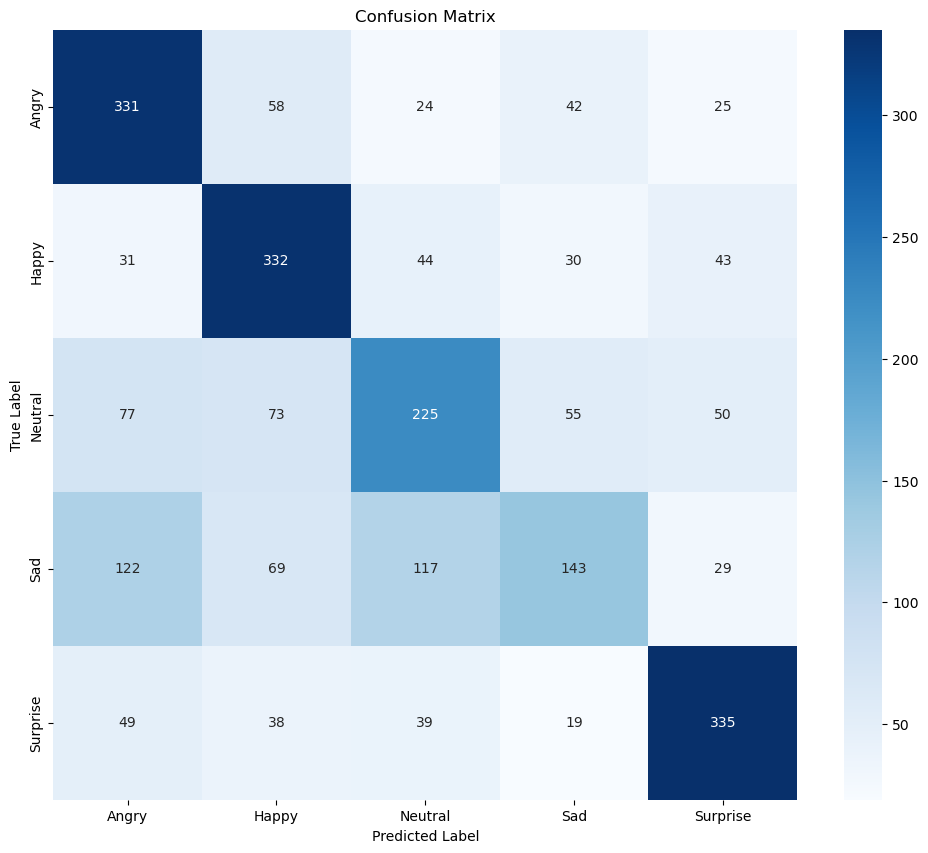

In [26]:
# genearting the confusion matrix
cm = confusion_matrix(x_true, x_prd)

# plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'],
            yticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

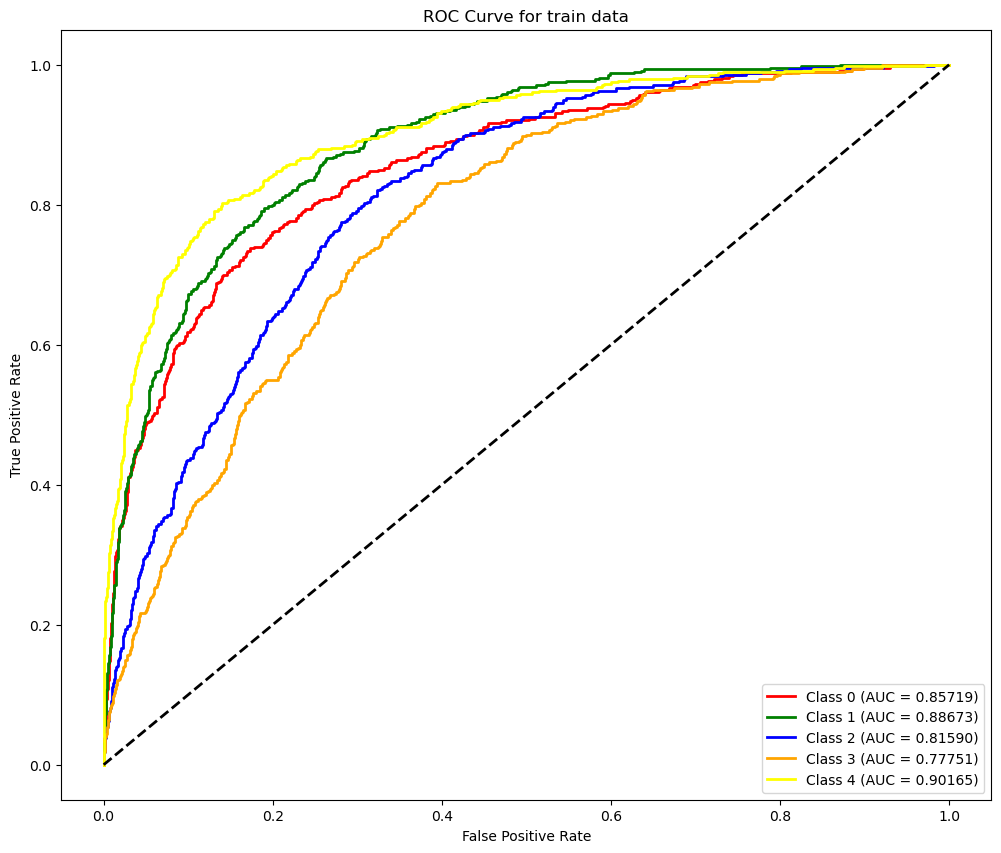

In [27]:
# performing AUC and ROC Curve for training data
Auc_trn = []
fpr_trn = []
tpr_trn = []
for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_train[:, i], x_pred[:, i])
    fpr_trn.append(fpr)
    tpr_trn.append(tpr)
    Auc_trn.append(auc(fpr, tpr))

# Plotting ROC curve for all class
plt.figure(figsize=(12, 10))
clr = ['red', 'green', 'blue', 'orange', 'yellow']

for i, color in zip(range(y_train.shape[1]), clr):
    plt.plot(fpr_trn[i], tpr_trn[i], color=color, lw=2, label=f'Class {i} (AUC = {Auc_trn[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for train data')
plt.legend(loc='lower right')
plt.show()

## Performance on Testing Data

In [28]:
# predicting the model on test data
y_pred = model.predict(X_test)

y_true_tst = np.argmax(y_test, axis=1)
y_prd_tst = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true_tst, y_prd_tst)
print(f'Test Accuracy:- {round(accuracy*100, 2)}%')

19/19 [==============================] - 28s 1s/step
Test Accuracy:- 52.5%


In [29]:
# getting the classification report
print(classification_report(y_true_tst, y_prd_tst))

              precision    recall  f1-score   support

           0       0.45      0.57      0.50       120
           1       0.58      0.68      0.62       120
           2       0.43      0.38      0.41       120
           3       0.49      0.33      0.39       120
           4       0.67      0.67      0.67       120

    accuracy                           0.53       600
   macro avg       0.52      0.53      0.52       600
weighted avg       0.52      0.53      0.52       600



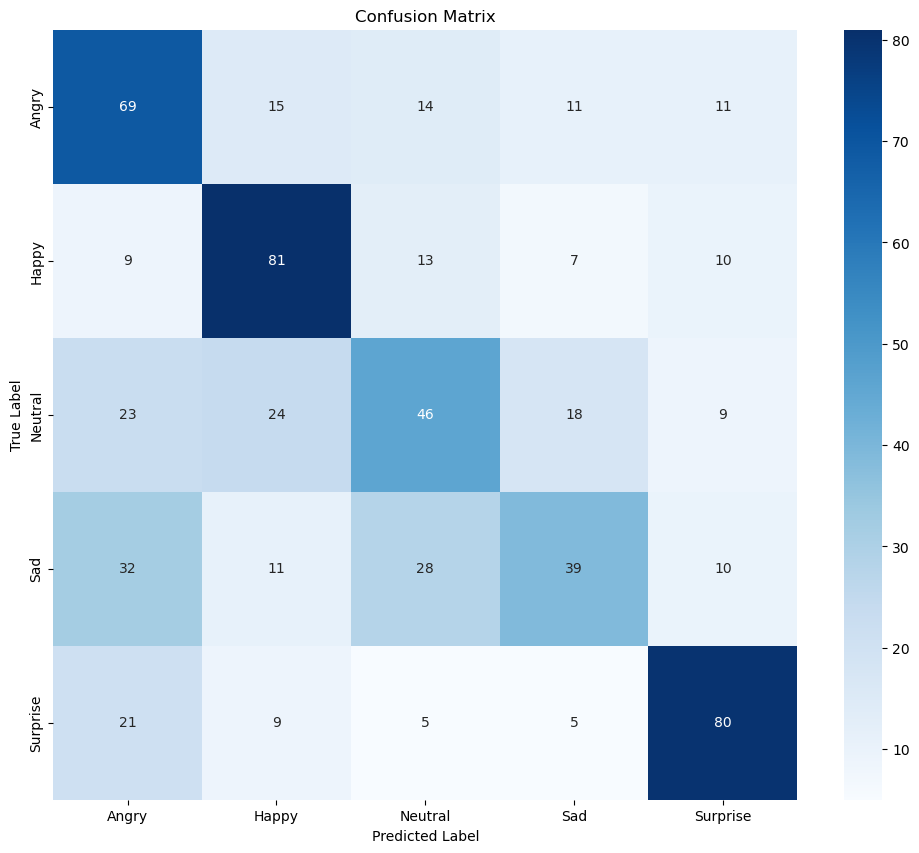

In [30]:
# genearting the confusion matrix
cm = confusion_matrix(y_true_tst, y_prd_tst)

# plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'],
            yticklabels=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

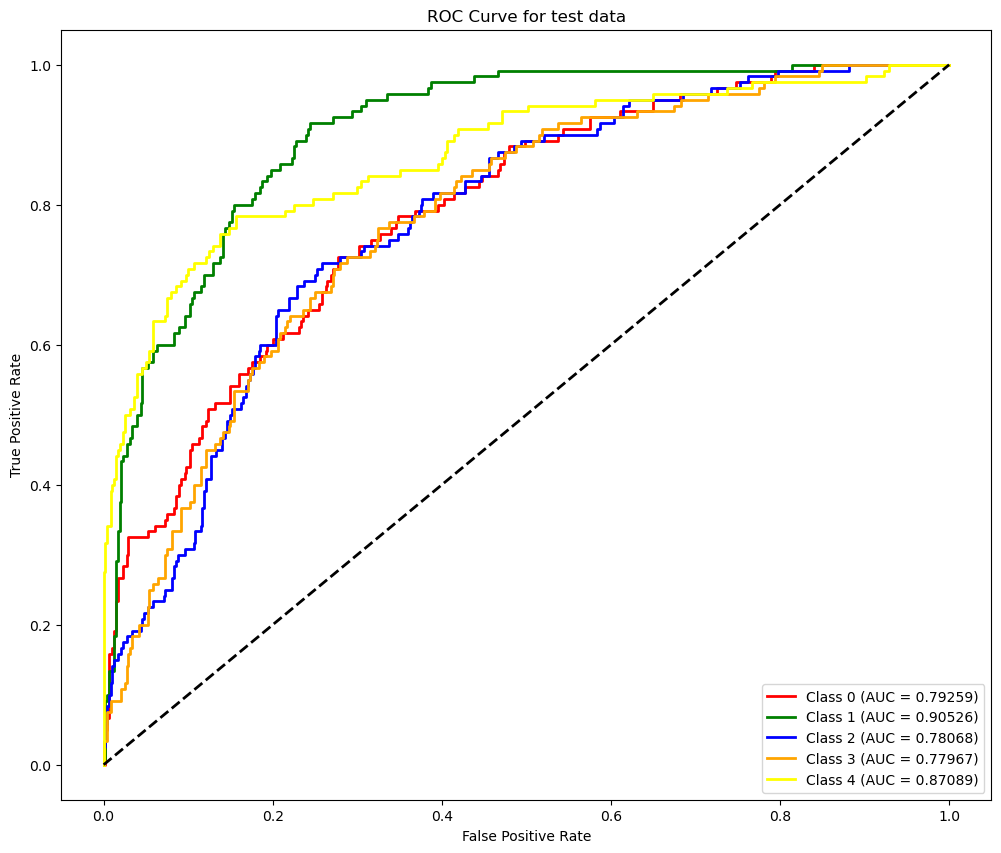

In [31]:
# performing AUC and ROC Curve for testing data
Auc_tst = []
fpr_tst = []
tpr_tst = []
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    fpr_tst.append(fpr)
    tpr_tst.append(tpr)
    Auc_tst.append(auc(fpr, tpr))

# Plotting ROC curve for all class
plt.figure(figsize=(12, 10))
clr = ['red', 'green', 'blue', 'orange', 'yellow']

for i, color in zip(range(y_test.shape[1]), clr):
    plt.plot(fpr_tst[i], tpr_tst[i], color=color, lw=2, label=f'Class {i} (AUC = {Auc_tst[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for test data')
plt.legend(loc='lower right')

plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 482ms/step


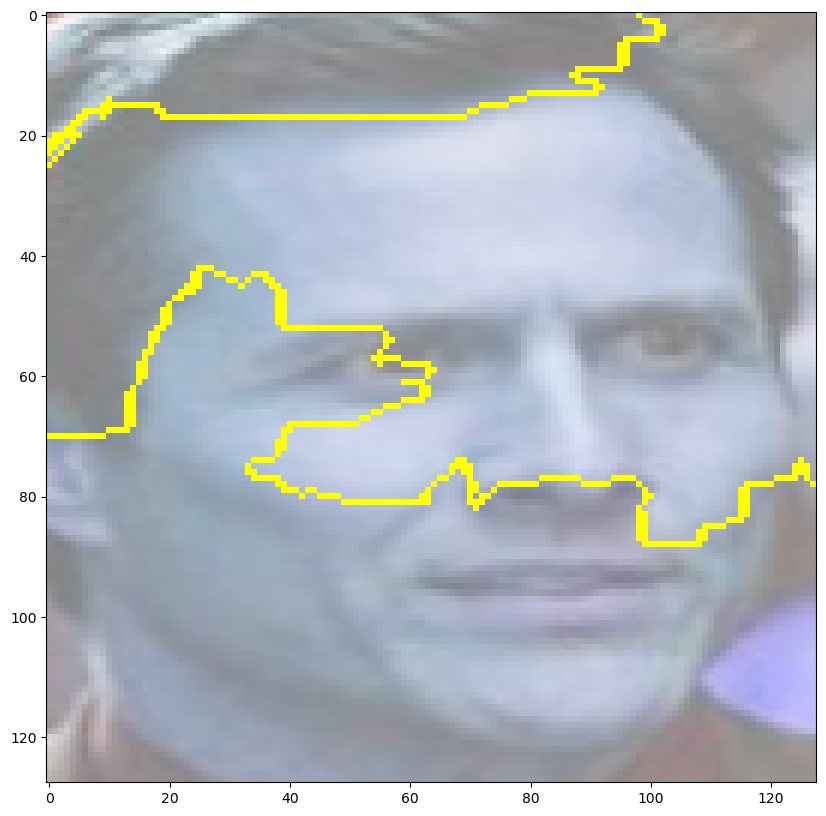

In [32]:
# performing the LIME
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime_predict(images):
    return model.predict(images)

exp = lime_image.LimeImageExplainer()
lime_image = X_test[1]
lime_label = np.argmax(y_test[1])

lime = exp.explain_instance(lime_image, lime_predict, top_labels=5, hide_color=0, num_samples=100)

temp, mask = lime.get_image_and_mask(lime_label, positive_only=True, num_features=5, hide_rest=False)

plt.figure(figsize=(12, 10))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()